# Изучение воронки продаж и исследование результатов
# A/A/B-эксперимента

# Описание проекта

Я работаю в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи моего мобильного приложения. 


Изучу воронку продаж. Узнаю, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?


После этого исследую результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.
Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.


В случае общей аналитики и A/A/B-эксперимента работать с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

# План работы

1) Изучить общую иформацию из файла.

2) Подготовить данные для анализа.

3) Изучить и проверить данные.

4) Построить и изучить воронку событий.

5) Изучить результаты A/A/B-эксперимента.


# Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

`EventName` — название события;

`DeviceIDHash` — уникальный идентификатор пользователя;

`EventTimestamp` — время события;

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

##  Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as st
import math as mth
from pandas.plotting import register_matplotlib_converters
import datetime as dt
from plotly import graph_objects as go
import seaborn as sns


In [2]:
data = pd.read_csv('/datasets/logs_exp.csv',sep='\t')
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


По исходному датафрейму можно сделать вывод, что в нем присутствуют ошибки.

##  Подготовьте данные

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
#data.columns = ['event_name', 'user_id', 'date_time', 'group']
data = data.rename(columns={"EventName": "event_name", "DeviceIDHash": "user_id","EventTimestamp": "date_time","ExpId": "group",})
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')
display(data.head())
print()
data.info()

,event_name,user_id,date_time,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   date_time   244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


Здесь я привел дату к нужному типу данных и переименовал столбцы под удобные мне названия.

In [6]:
print(data.isna().sum())
print()
print(data.duplicated().sum())
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

event_name    0
user_id       0
date_time     0
group         0
dtype: int64

413


0

Пропусков в датафрейме не было, но было 413 дубликатов, которые я отбросил.

In [7]:
data['date'] = data['date_time'].dt.date
data['date'] = pd.to_datetime(data['date'])
display(data)
data.info()

,event_name,user_id,date_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   date_time   243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


Добавил отдельный столбец с датами и привел его к нужному типу.

In [8]:
Aorders = data[data['group'] == '246']['user_id']
A2orders = data[data['group'] == '247']['user_id']

display(Aorders.isin(A2orders).sum())
s1 = pd.merge(Aorders, A2orders, how='inner', on=['user_id'])
s1['user_id'].nunique()

0

0

In [9]:
Aorders = data[data['group'] == '246']['user_id']
Borders = data[data['group'] == '248']['user_id']

display(Aorders.isin(Borders).sum())
s1 = pd.merge(Aorders, Borders, how='inner', on=['user_id'])
s1['user_id'].nunique()

0

0

In [10]:
A2orders = data[data['group'] == '247']['user_id']
Borders = data[data['group'] == '248']['user_id']

display(A2orders.isin(Borders).sum())
s1 = pd.merge(A2orders, Borders, how='inner', on=['user_id'])
s1['user_id'].nunique()

0

0

При проверки попадания пользователей сразу в несколько групп, ошибок не найдено, и каждый пользователь находится только в своей группе.

<b>По итогам подготовки данных к анализу, ошибки в типах данных были устранены, пропусков в данных не было обнаружено, дубликаты убраны из датафрейма. Названия столбцов были заменены на удобные для меня и был добавлен отдельный столбец с датами. И каждой пользователь находится только в своей группе.</b>

##  Изучите и проверьте данные

In [11]:

print('Всего событий в логе:', data['user_id'].count())

print('Всего пользователей в логе:', data['user_id'].nunique())

print('В среднем событий приходится на пользователя:',round(data.groupby('user_id')['event_name'].count().mean(),0))


Всего событий в логе: 243713
Всего пользователей в логе: 7551
В среднем событий приходится на пользователя: 32.0


Минимальная и максимальная дата:
min   2019-07-25
max   2019-08-07
Name: date, dtype: datetime64[ns]


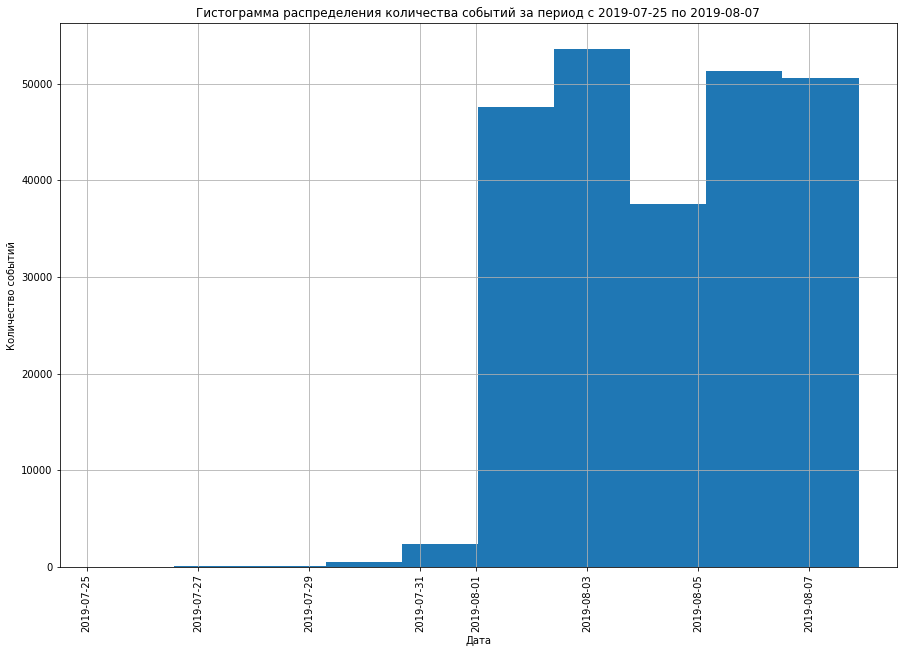

In [12]:
print('Минимальная и максимальная дата:')
print(data['date'].agg(['min', 'max']))
plt.figure(figsize=(15, 10))

data['date_time'].hist()

plt.xticks(rotation=90)
plt.title('Гистограмма распределения количества событий за период с 2019-07-25 по 2019-08-07')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.show()

Посмотрев на гистограмму можно сказать, что на самом деле мы располагаем данными от '2019-07-31'. Я считаю что данные полные уже с '2019-08-01' и поэтому все остальные даты до этой, я отбросил.

In [13]:
data_new = data[data['date_time'] >= '2019-08-01']

print('Всего событий в логе:', data_new['user_id'].count())

print('Всего пользователей в логе:', data_new['user_id'].nunique())

print('В среднем событий приходится на пользователя:',round(data_new.groupby('user_id')['event_name'].count().mean(),0))

Всего событий в логе: 240887
Всего пользователей в логе: 7534
В среднем событий приходится на пользователя: 32.0


In [14]:
lost_event = data['user_id'].count() - data_new['user_id'].count()
print('Потеря событий в логе:', lost_event)
print('Потеря событий в логе в процентах:', round((lost_event/data['user_id'].count())*100,1),'%')

lost_users = data['user_id'].nunique() - data_new['user_id'].nunique()
print('Потеря пользователей в логе:', lost_users)
print('Потеря пользователей в логе в процентах:', round((lost_users/data['user_id'].nunique())*100,1),'%')

lost_mean = round(data.groupby('user_id')['event_name'].count().mean(),0) - round(data_new.groupby('user_id')
                                                                                  ['event_name'].count().mean(),0)

print('Потеря в среднем событий приходихся на пользователя:', lost_mean)



Потеря событий в логе: 2826
Потеря событий в логе в процентах: 1.2 %
Потеря пользователей в логе: 17
Потеря пользователей в логе в процентах: 0.2 %
Потеря в среднем событий приходихся на пользователя: 0.0


Отбросив старые данные, я потерял 2826 событий и 17 пользователей. А в среднем событий приходится на пользователя 32 как и было. Отбросив старые данные я потерял  1,2% событий и 0,2% пользователей, что очень мало.

In [15]:
print('Количество пользователей в каждой группе:')
data_new.groupby('group')['user_id'].agg({'nunique'})

Количество пользователей в каждой группе:


,nunique
group,
246,2484
247,2513
248,2537


Пользователи остались из всех трех эксперимаентальных групп.

##  Изучите воронку событий 

In [16]:
print(data_new['event_name'].value_counts())

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64


Самым частым событием является событие MainScreenAppear (117328). А событие Tutorial (1005) самое редкое.

In [17]:
df = data_new.groupby('event_name')['user_id'].agg({'nunique'}).sort_values(by = 'nunique' ,ascending=False)

df.columns = ['user_cnt']

df['user_share'] = round(df['user_cnt']/data_new['user_id'].nunique() * 100,2) 

df

,user_cnt,user_share
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


Посчитал сколько пользователей совершали каждое из этих событий. Самое большое количество пользователей у события MainScreenAppear (7419) и самое маленькое количество пользователей у события Tutorial (840). Также посчитал  долю пользователей, которые хоть раз совершали событие. Событие MainScreenAppear совершали почти 100% пользователей (98,47%). Так же около 1.5 % миновало главный экран, возможно это связано с тем, что после обучения, им не захотелось дальше пользоваться приложением.

In [18]:
data_new = data_new.query('event_name !="Tutorial"')
df = df.query('event_name !="Tutorial"')

Я предположил, что события происходят в таком порядке:

1) MainScreenAppear
    
2) OffersScreenAppear
    
3) CartScreenAppear
    
4) PaymentScreenSuccessful
    
Так события выстраиваются в логичную цепочку. Что получается и логично для воронки, от большего числа пользователей к меньшему.

Так же для расчета воронки, я отбросил данные события Tutorial (руководство/инструкция). Потому что это событие ,скорее всего, большинство людей пропускало.
    

In [19]:
share = round(df['user_cnt']/df['user_cnt'].shift(periods=1) * 100,1)
share.fillna('100')

event_name
MainScreenAppear            100
OffersScreenAppear         61.9
CartScreenAppear           81.3
PaymentScreenSuccessful    94.8
Name: user_cnt, dtype: object

Здесь у первого события пропуск, я заменил на значение 100%, так как это первое событие и до него ничего небыло.

Больше всего людей теряется с шага 'MainScreenAppear' на 'OffersScreenAppear'. Теряется 38.2%. Что и логично, люди после главного меню, просто выходят из приложения так как их ничего не заинтересовало.

In [20]:
print('Доля пользователей которые доходят от первого события до оплаты:',
      round(df['user_cnt'].iloc[3]/df['user_cnt'].iloc[0] * 100,1),'% ,что составляет почти половину от всех пользователей.')

Доля пользователей которые доходят от первого события до оплаты: 47.7 % ,что составляет почти половину от всех пользователей.


По результатам анализа воронки, я откинул событие Tutoria потому что обычно его можно пройти по желанию и на любом этапе, так же выяснил, что самое большое количество пользователей у события MainScreenAppear. Еще больше всего людей теряется с шага 'MainScreenAppear' на 'OffersScreenAppear' (38.2% потери). Но из хороших новостей, почти половина пользователей (47.7%) доходят от первого события до оплаты.

## Изучите результаты эксперимента

In [21]:
print('Пользователей в каждой экспериментальной группе:')
user_group = data_new.groupby('group')['user_id'].agg({'nunique'})
user_group

Пользователей в каждой экспериментальной группе:


,nunique
group,
246,2483
247,2512
248,2535


Больше всего пользователей в группе 248 их число составляет 2535.

### Проверка разницы между выборками 246 и 247.

Сделал сводную таблицу с распределением пользователей по группам и событиям.

In [22]:
users_event = pd.pivot_table(data_new, values='user_id', index='group', aggfunc='nunique',columns = 'event_name')
display(users_event)
multi_user = users_event.join(user_group,how = 'inner')
multi_user

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
group,,,,
246,1266,2450,1542,1200
247,1238,2476,1520,1158
248,1230,2493,1531,1181


,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,nunique
group,,,,,
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
248,1230,2493,1531,1181,2535


<b>Функция для проверки гипотез о равенстве долей

Нулевая гипотеза: Обе доли проверяемых событий  между сравниваемыми группами равны между собой.

Альтернативная гипотеза: Обе доли проверяемых событий  между сравниваемыми группами не равны между собой.

Значение alpha приму за 0,05.

Буду пользоваться проверкой гипотез о равенстве долей. (z-тест)

In [23]:
def group_stat(successes1,successes2,trials1,trials2,alpha):
    alpha = alpha # критический уровень статистической значимости

    successes = np.array([successes1, successes2])
    trials = np.array([trials1, trials2])

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаю статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаю стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 
     

In [24]:
list = [0,1,2]
print('Подсчет долей события CartScreenAppear для групп 246,247,248:')
for b in list:
    print(round(multi_user.iloc[b,0]/multi_user.iloc[b,4] * 100,1))

print()
print('Подсчет долей события MainScreenAppear для групп 246,247,248:')
for b in list:
    print(round(multi_user.iloc[b,1]/multi_user.iloc[b,4] * 100,1))
    
print()
print('Подсчет долей события OffersScreenAppear для групп 246,247,248:')
for b in list:
    print(round(multi_user.iloc[b,2]/multi_user.iloc[b,4] * 100,1)) 
    
print()
print('Подсчет долей события PaymentScreenSuccessful для групп 246,247,248:')
for b in list:
    print(round(multi_user.iloc[b,2]/multi_user.iloc[b,4] * 100,1))  

Подсчет долей события CartScreenAppear для групп 246,247,248:
51.0
49.3
48.5

Подсчет долей события MainScreenAppear для групп 246,247,248:
98.7
98.6
98.3

Подсчет долей события OffersScreenAppear для групп 246,247,248:
62.1
60.5
60.4

Подсчет долей события PaymentScreenSuccessful для групп 246,247,248:
62.1
60.5
60.4


Отдельно посчитали долю пользователей, совершивших эти события для каждой группы. Вы итоге получилось, что самая большая доля пользователей для каждой группы у события MainScreenAppear, а самая маленькая доля пользователей для каждой группы у события CartScreenAppear.

Самое популрное событие это MainScreenAppear.

In [25]:
multi_user

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,nunique
group,,,,,
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
248,1230,2493,1531,1181,2535


In [26]:
event_list = [1,0,2,3]
for i in event_list:
    print('Проверка гипотезы о равенстве долей для события',users_event.columns[i],'между группами 246 и 247')
    group_stat(multi_user.iloc[0,i],
           multi_user.iloc[1,i],
           multi_user.iloc[0,4],
           multi_user.iloc[1,4],0.05)    
    print()
    print()

Проверка гипотезы о равенстве долей для события MainScreenAppear между группами 246 и 247
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события CartScreenAppear между группами 246 и 247
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события OffersScreenAppear между группами 246 и 247
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события PaymentScreenSuccessful между группами 246 и 247
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




<b>Ни в одной из проверок не удалось отвергнуть нулевую гипотезу и поэтому нет оснований считать доли разными. Поэтому можно сказать, что разбиение на группы работает корректно.

In [27]:
for i in event_list:
    print('Проверка гипотезы о равенстве долей для события',users_event.columns[i],'между группами 246 и 248')
    group_stat(multi_user.iloc[0,i],
           multi_user.iloc[2,i],
           multi_user.iloc[0,4],
           multi_user.iloc[2,4],0.05)    
    print()
    print()

Проверка гипотезы о равенстве долей для события MainScreenAppear между группами 246 и 248
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события CartScreenAppear между группами 246 и 248
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события OffersScreenAppear между группами 246 и 248
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события PaymentScreenSuccessful между группами 246 и 248
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




<b>При проверке разницы долей между контрольной группой 246 и экспериментальной группой 248 в отдельности по каждому событию, разницы между долями не были обнаружены.

In [28]:
for i in event_list:
    print('Проверка гипотезы о равенстве долей для события',users_event.columns[i],'между группами 247 и 248')
    group_stat(multi_user.iloc[1,i],
           multi_user.iloc[2,i],
           multi_user.iloc[1,4],
           multi_user.iloc[2,4],0.05)    
    print()
    print()

Проверка гипотезы о равенстве долей для события MainScreenAppear между группами 247 и 248
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события CartScreenAppear между группами 247 и 248
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события OffersScreenAppear между группами 247 и 248
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события PaymentScreenSuccessful между группами 247 и 248
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




<b>При проверке разницы долей между контрольной группой 247 и экспериментальной группой 248 в отдельности по каждому событию, разницы между долями не были обнаружены.

Суммируем группы 246 и 247.

In [29]:
multi_user.loc['246&247'] = multi_user.iloc[:2].sum(axis=0)
display(multi_user)

,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,nunique
group,,,,,
246,1266,2450,1542,1200,2483
247,1238,2476,1520,1158,2512
248,1230,2493,1531,1181,2535
246&247,2504,4926,3062,2358,4995


In [30]:
for i in event_list:
    print('Проверка гипотезы о равенстве долей для события',users_event.columns[i],'между группами 246&247 и 248')
    group_stat(multi_user.iloc[3,i],
           multi_user.iloc[2,i],
           multi_user.iloc[3,4],
           multi_user.iloc[2,4],0.05)    
    print()
    print()

Проверка гипотезы о равенстве долей для события MainScreenAppear между группами 246&247 и 248
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события CartScreenAppear между группами 246&247 и 248
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события OffersScreenAppear между группами 246&247 и 248
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события PaymentScreenSuccessful между группами 246&247 и 248
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




<b>Так же при проверке разницы долей между суммой контрольных групп 246&247 и экспериментальной группой 248 в отдельности по каждому событию, разницы между долями не были обнаружены.

Вывод из экспиремента: После проведения A/A/B теста, значимой разницы между долями не было обнаружено. Поэтому тест можно признать успешным, так как оснвоной целью было узнать не отпугнет ли новый шрифт пользователей.

<b>При проверке статистических гипотез, я выбрал уровень знаимости равный 0.05 и при таком уровне значимости каждый двацатый раз можно получить ложный результат. А я сделал 16 проверок статистических гипотез. Поэтому предполагаю, что все ннормально, и ошибок быть не должно.

In [31]:
for i in event_list:
    print('Проверка гипотезы о равенстве долей для события',users_event.columns[i],'между группами 247 и 248')
    group_stat(multi_user.iloc[1,i],
           multi_user.iloc[2,i],
           multi_user.iloc[1,4],
           multi_user.iloc[2,4],0.01)    
    print()
    print()



for i in event_list:
    print('Проверка гипотезы о равенстве долей для события',users_event.columns[i],'между группами 246&247 и 248')
    group_stat(multi_user.iloc[3,i],
           multi_user.iloc[2,i],
           multi_user.iloc[3,4],
           multi_user.iloc[2,4],0.01)    
    print()
    print()

Проверка гипотезы о равенстве долей для события MainScreenAppear между группами 247 и 248
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события CartScreenAppear между группами 247 и 248
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события OffersScreenAppear между группами 247 и 248
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события PaymentScreenSuccessful между группами 247 и 248
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о равенстве долей для события MainScreenAppear между группами 246&247 и 248
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований 

# Вывод

В ходе проектной работы, сначала я подготовил данные для анализа. Поменял названия столбцов, избавился от дубликатов и изменил тип данных, где это было нужно. Других ошибок не было найдено.

Затем я изучил и проверил данные. Окалось, что данные до 2019-08-01 не несут никакой информации, поэтому я отбросил их. Отброшенных данных по событиям в логе в было 1.2 %, а отброшенных данных по пользователям в логе было 0.2 %, что очень очень мало и не критично для дальнейшего анализа данных.

Потом я сделал воронку событий, для начала я посчитал сколько пользователей совершали каждое из событий. Самое большое количество пользователей у события MainScreenAppear (7419) и самое маленькое количество пользователей у события Tutorial (840). Также посчитал долю пользователей, которые хоть раз совершали событие. Событие MainScreenAppear совершали почти 100% пользователей (98,47%). Так же около 1.5 % миновало главный экран, возможно это связано с тем, что после обучения, им не захотелось дальше пользоваться приложением. Так же для дальнейшего расчета воронки, я отбросил данные события Tutorial (руководство/инструкция). Потому что это событие ,скорее всего, большинство людей пропускало. Дальше при построении воронки обнаружил, что больше всего людей теряется с шага 'MainScreenAppear' на 'OffersScreenAppear'. Теряется 38.2%. А доля пользователей которые доходят от первого события до оплаты составляет 47.7 %.

В конце я изучил результаты A/A/B теста. Значение alpha я принял за 0,05. И пользовался z-тестом (z-критерий Фишера). После проверки гипотез для всех 16 тестов, не было основанний считать доли разными. При проверке со статистической значимостью 0.01, так же все тесты показали, что нулевая гипотеза верна. Поэтому по итогу эксперимент можно считать успешным, так как основной целью было сохранить пользователей после изменения шрифта.